In [2]:
%cd ..

/home/bhkuser/bhklab/katy/readii_2_roqc


In [3]:
from damply import dirs
from pathlib import Path
from tqdm import tqdm
from joblib import Parallel, delayed

from imgtools.io.writers.nifti_writer import NIFTIWriter, NiftiWriterIOError

from readii.process.images.crop import crop_and_resize_image_and_mask
from readii.negative_controls_refactor.manager import NegativeControlManager

from readii_2_roqc.utils.loaders import load_dataset_config, load_image_and_mask
from readii_2_roqc.utils.metadata import get_masked_image_metadata, insert_SampleID
from readii_2_roqc.utils.settings import get_readii_settings, get_resize_string

import pandas as pd
import itertools
import logging
import SimpleITK as sitk

In [ ]:
dataset = "NSCLC-Radiomics_test"
overwrite = True
seed = 10

# Set up logging

In [ ]:
logger = logging.getLogger(__name__)
logging.basicConfig(filename = dirs.LOGS / f"{dataset}_make_negative_controls.log", encoding='utf-8', level=logging.DEBUG)

# Load dataset config

In [ ]:
if dataset is None:
    message = "Dataset name must be provided."
    logger.error(message)
    raise ValueError(message)

dataset_config, dataset_name, full_dataset_name = load_dataset_config(dataset)
# logger.info(f"Creating negative controls for dataset: {dataset_name}")

# Load dataset index

In [ ]:
images_dir_path = dirs.PROCDATA / full_dataset_name / 'images'

dataset_index = pd.read_csv(images_dir_path / f'mit_{dataset_name}' / f'mit_{dataset_name}_index-simple.csv')
dataset_index = insert_SampleID(dataset_index)

# Filter the index by R2R configuration file

In [ ]:
masked_image_index = get_masked_image_metadata(dataset_index, dataset_config)

# Check for output(s) existence

In [ ]:
regions, permutations, crop, resize = get_readii_settings(dataset_config)

readii_image_dir = images_dir_path / f'readii_{dataset_name}'

if crop != "" and resize != []:
    readii_index_filepath = readii_image_dir / f"{crop}_{get_resize_string(resize)}" / f'readii_{dataset_name}_index.csv'
else:
    readii_index_filepath = readii_image_dir.glob(f"original_*/readii_{dataset_name}_index.csv").__next__()

In [ ]:
if readii_index_filepath.exists() and not overwrite:
    regions, permutations, crop, resize = get_readii_settings(dataset_config)
    # Load in readii index and check:
    # 1. if all negative controls requested have been extracted
    # 2. for all of the patients
    readii_index = pd.read_csv(readii_index_filepath)

    # Get list of patients that have already been processed and what has been requested based on the dataset index
    processed_samples = set(readii_index['PatientID'].to_list())
    requested_samples = set(dataset_index['SampleID'].to_list())


    readii_settings = ['Permutation', 'Region', 'crop', 'Resize']
    if not set(readii_index.columns).issuperset(readii_settings):
        print("Not all READII settings satisfied in existing output. Re-running negative control generation.")
    
    else:
        processed_image_types = {itype for itype in readii_index[readii_settings].itertuples(index=False, name=None)}
        requested_image_types = {itype for itype in itertools.product(permutations,
                                                                      regions,
                                                                      [crop],
                                                                      [get_resize_string(resize)])}
        if requested_image_types.issubset(processed_image_types) and requested_samples.issubset(processed_samples):
            print("All requested negative controls have already been generated for these samples or are listed in the readii index as if they have been. Set overwrite to true if you want to re-process these.")

# Negative control generator function that can be run in parallel

In [ ]:
def negative_control_generator(sample_id:str,
                               image:sitk.Image,
                               mask:sitk.Image,
                               regions, 
                               permutations, 
                               crop, 
                               resize,
                               image_meta_id,
                               mask_meta_id,
                               nifti_writer:NIFTIWriter,
                               seed = 10
                               ):
    negative_control_image_paths = []

    # Set up negative control manager with settings from config
    manager = NegativeControlManager.from_strings(
        negative_control_types=permutations,
        region_types=regions,
        random_seed=seed
    )
    # Process and save negative control images
    for proc_image, permutation, region in manager.apply(image, mask):
        # apply crop and resize
        if crop != "" and resize != []:
            proc_image, proc_mask = crop_and_resize_image_and_mask(proc_image, 
                                                                   mask, 
                                                                   crop_method = crop, 
                                                                   resize_dimension = resize)
        # save out negative controls
        try:
            # The capitalized arguments are here on purpose to manipulate the order of the columns in the index file
            out_path = nifti_writer.save(
                            proc_image,
                            ImageID = image_meta_id,
                            MaskID = mask_meta_id,
                            Permutation="original",
                            Region="full",
                            Resize=get_resize_string(resize),
                            SampleID=sample_id,
                            crop=crop
                        )
        except NiftiWriterIOError:
            message = f"{permutation} {region} negative control file already exists for {sample_id}. If you wish to overwrite, set overwrite to True."
            logger.debug(message)
        
        negative_control_image_paths.append(out_path)

    return negative_control_image_paths

In [ ]:
def image_preprocessor(dataset_config:dict, 
                        image_path:Path, 
                        mask_path:Path, 
                        images_dir_path:Path, 
                        output_dir:Path, 
                        sample_id:str = None, 
                        mask_image_id:str = None, 
                        overwrite:bool = False):
    if overwrite:
        existing_file_mode = 'OVERWRITE'
        overwrite_index = True
    else:
        existing_file_mode = 'SKIP'
        overwrite_index = False

    regions, permutations, crop, resize = get_readii_settings(dataset_config)
    resize_string = get_resize_string(resize)

    # Get sample metadata from path if not provided
    if sample_id is None:
        sample_id = Path(image_path).parts[0]
    if mask_image_id is None:
        mask_image_id = Path(mask_path).name.removesuffix('.nii.gz')
    
    # Get beginning of the path to the nifti images dir
    mit_images_dir = images_dir_path / f'mit_{dataset_name}'
    # load in the nifti image and mask files, flattened to 3D and aligned with each other
    image, mask = load_image_and_mask(mit_images_dir / image_path, mit_images_dir / mask_path)
    # get image modality for file writer
    image_modality = dataset_config['MIT']['MODALITIES']['image']
    # make image identifier string for file writer
    image_meta_id = f"{image_path.parent.name}"
    # make mask identifier string for file writer
    mask_meta_id = f"{mask_path.parent.name}_{mask_image_id.replace(' ', "_")}"

    # Set up the readii subdirectory for the image being processed, specifically the crop and resize level
    if crop == '' and resize == []:
        # get the original image size to use for output directory, without the slice count
        image_size_string = get_resize_string(image.GetSize()[0:2])
        # make the slice index an n since different images have different slice counts
        crop_setting_string = f'original_{image_size_string}_n'
    else:
        crop_setting_string = f'{crop}_{resize_string}'

    # Set up writer for saving out the negative controls and index file
    nifti_writer = NIFTIWriter(
            root_directory = output_dir / crop_setting_string,
            filename_format = f"{image_path.parent}/{mask_meta_id}/{image_modality}" + "_{Permutation}_{Region}.nii.gz",
            create_dirs = True,
            existing_file_mode = existing_file_mode,
            sanitize_filenames = True,
            index_filename = f"readii_{dataset_name}_index.csv",
            overwrite_index = overwrite_index
        )
    
    readii_image_paths = []
    # Process crop and resize of original image if needed, and save
    if crop != '' and resize != []:
        crop_image, crop_mask = crop_and_resize_image_and_mask(image, 
                                                               mask, 
                                                               crop_method = crop, 
                                                               resize_dimension = resize)
        # save out cropped image
        try:
            # The capitalized arguments are here on purpose to manipulate the order of the columns in the index file
            out_path = nifti_writer.save(
                            crop_image,
                            ImageID = image_meta_id,
                            MaskID = mask_meta_id,
                            Permutation="original",
                            Region="full",
                            Resize=resize_string,
                            SampleID=sample_id,
                            crop=crop
                        )
        except NiftiWriterIOError:
            message = f"{crop} {resize_string} original image file already exists for {sample_id}. If you wish to overwrite, set overwrite to True."
            logger.debug(message)
        
        readii_image_paths.append(out_path)
    # end original image processing

    if permutations != [] and regions != []:
        negative_control_image_paths = negative_control_generator(sample_id=sample_id,
                                                                  image = image,
                                                                  mask = mask,
                                                                  regions = regions,
                                                                  permutations = permutations,
                                                                  crop = crop,
                                                                  resize = resize,
                                                                  image_meta_id = image_meta_id,
                                                                  mask_meta_id = mask_meta_id,
                                                                  nifti_writer = nifti_writer)
        readii_image_paths.append(negative_control_image_paths)
    
    return readii_image_paths


In [ ]:
from readii_2_roqc.utils.metadata import make_edges_df

edges_index = make_edges_df(masked_image_index, dataset_config['MIT']['MODALITIES']['image'], dataset_config['MIT']['MODALITIES']['mask'])
parallel = True
n_jobs = 4

if parallel:
    # Use joblib to parallelize negative control generation
    readii_image_paths = Parallel(n_jobs=n_jobs)(
                            delayed(image_preprocessor)(
                                dataset_config=dataset_config, 
                                image_path=Path(data_row.filepath_image), 
                                mask_path=Path(data_row.filepath_mask), 
                                images_dir_path=images_dir_path, 
                                output_dir=readii_image_dir,
                                sample_id=data_row.SampleID_image,
                                mask_image_id=data_row.ImageID_mask, 
                                overwrite=overwrite
                            )
                            for _, data_row in tqdm(
                                edges_index.iterrows(),
                                desc="Generating negative controls for each image-mask pair...",
                                total=len(edges_index)
                            )
                        )
else:
    readii_image_paths = [image_preprocessor(dataset_config=dataset_config, 
                                            image_path=Path(data_row.filepath_image), 
                                            mask_path=Path(data_row.filepath_mask), 
                                            images_dir_path=images_dir_path, 
                                            output_dir=readii_image_dir,
                                            sample_id=data_row.SampleID_image,
                                            mask_image_id=data_row.ImageID_mask, 
                                            overwrite=overwrite
                                            ) for _, data_row in tqdm(edges_index.iterrows(),
                                                                        desc="Generating negative controls for each image-mask pair...",
                                                                        total=len(edges_index))]
 


# Debugging "Requested region is outside largest possible region"

In [4]:
image = sitk.ReadImage("data/procdata/TCIA_CPTAC-CCRCC/images/mit_iso_CPTAC-CCRCC/C3L-00766_0000/CT_30594430/CT.nii.gz")
mask = sitk.ReadImage("data/procdata/TCIA_CPTAC-CCRCC/images/mit_iso_CPTAC-CCRCC/C3L-00766_0000/RTSTRUCT_733567.4/GTV__[RT_KIDNEY-1].nii.gz")

crop = 'cube'
resize = [50,50,50]

cropped_image, cropped_mask = crop_and_resize_image_and_mask(image, 
                                mask, 
                                crop_method = crop, 
                                resize_dimension = resize)

In [5]:
cropped_image.GetSize()

(50, 50, 50)

<Axes: >

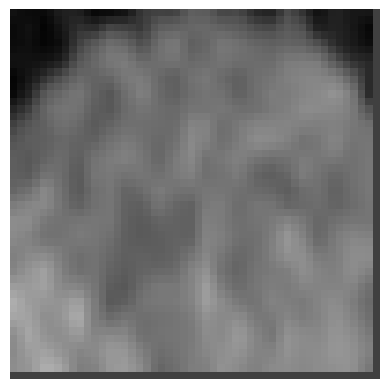

In [6]:
from readii.image_processing import displayCTSegOverlay, displayImageSlice

displayImageSlice(cropped_image, 25, dispMin=-100, dispMax=400)

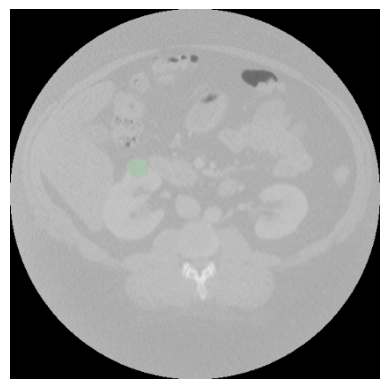

In [7]:
displayCTSegOverlay(image, mask, alpha=0.1)

In [8]:
from imgtools.coretypes.box import RegionBox, calculate_image_boundaries, Coordinate3D
from imgtools.transforms.functional import resize
import numpy as np

crop_box = RegionBox.from_mask_bbox(mask)
print(crop_box)

crop_cube = crop_box.expand_to_cube()
print(crop_cube)

RegionBox(
	min=Coordinate3D(x=133, y=169, z=288),
	max=Coordinate3D(x=156, y=192, z=308)
	size=Size3D(w=23, h=23, d=20)
)
RegionBox(
	min=Coordinate3D(x=133, y=169, z=286),
	max=Coordinate3D(x=156, y=192, z=309)
	size=Size3D(w=23, h=23, d=23)
)


In [101]:
np.min(Coordinate3D(image.GetSize()).to_tuple())

np.int64(61)

In [89]:
calculate_image_boundaries(image, False)

RegionBox(
	min=Coordinate3D(x=0, y=0, z=0),
	max=Coordinate3D(x=512, y=512, z=61)
	size=Size3D(w=512, h=512, d=61)
)

In [88]:
calculate_image_boundaries(image, True)

RegionBox(
	min=Coordinate3D(x=-196.8000030517578, y=-163.39999389648438, z=-304.75),
	max=Coordinate3D(x=315.1999969482422, y=348.6000061035156, z=-243.75)
	size=Size3D(w=512, h=512, d=61)
)

In [38]:
crop_cube.check_out_of_bounds_coordinates(image)
print(crop_cube)

RegionBox(
	min=Coordinate3D(x=146, y=268, z=-8),
	max=Coordinate3D(x=215, y=337, z=61)
	size=Size3D(w=69, h=69, d=69)
)


In [44]:
crop_cube._adjust_negative_coordinates(Coordinate3D(0,0,0), Coordinate3D(image.GetSize()))

In [45]:
crop_cube

RegionBox(
	min=Coordinate3D(x=146, y=268, z=0),
	max=Coordinate3D(x=215, y=337, z=69)
	size=Size3D(w=69, h=69, d=69)
)

In [65]:
arr_image = sitk.GetArrayFromImage(image)
arr_image.shape

(61, 512, 512)

<Axes: >

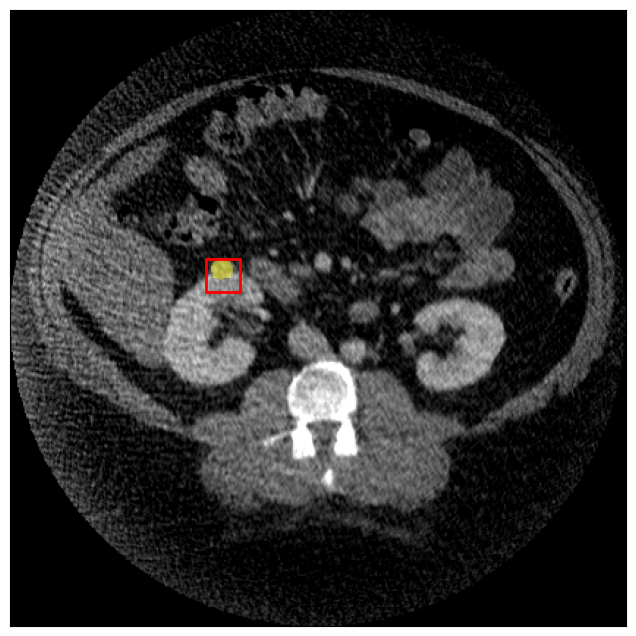

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_bbox(image: np.ndarray, bbox: np.ndarray, slice_idx: int, vmin=-100, vmax=300):
    """
    Overlay the bounding box on the image.
    """
    image = image[slice_idx]
    x_min, y_min, x_max, y_max = bbox

    # Create a figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Display the image
    ax.imshow(image, cmap='gray', vmax=vmax, vmin=vmin)
    
    # Draw rectangle on the plot
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                        fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Remove axes ticks
    ax.set_xticks([])
    ax.set_yticks([])

    return ax

def show_mask(mask, ax, mask_color=None, alpha=0.5):
    """
    show mask on the image

    Parameters
    ----------
    mask : numpy.ndarray
        mask of the image
    ax : matplotlib.axes.Axes
        axes to plot the mask
    mask_color : numpy.ndarray
        color of the mask
    alpha : float
        transparency of the mask
    """
    if mask_color is not None:
        color = np.concatenate([mask_color, np.array([alpha])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, alpha])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    return ax

slice_idx = 290
ax = overlay_bbox(sitk.GetArrayFromImage(image), bbox=[crop_cube.min[0], crop_cube.min[1], crop_cube.max[0], crop_cube.max[1]], slice_idx=slice_idx)
mask_slice = sitk.GetArrayFromImage(mask)[slice_idx]
show_mask(mask_slice, ax)

In [61]:
image.GetSize()

(512, 512, 61)